This notebook contains 4 models using a TFIDF Feature Vectoriser 
1. MLP 
2. LSTM 
3. BILSTM 
4. BILSTM WITH MAX POOLING

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-challenge/train_stances.csv
/kaggle/input/fake-news-challenge/test_stances_unlabeled.csv
/kaggle/input/fake-news-challenge/train_bodies.csv
/kaggle/input/fake-news-challenge/competition_test_bodies.csv
/kaggle/input/fake-news-challenge/competition_test_stances_unlabeled.csv
/kaggle/input/fake-news-challenge/test_bodies.csv
/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_train.csv
/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_validation.csv
/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_test.csv
/kaggle/input/lemma-final-fnc/lemmatized_dataset_final.csv


In [2]:
##dervived from UCL - 3RD PLACE CHALLENGE FOR FNC BUT EDITED TO NOT FIT TEST SET OVER TF-IDF VECTORIUSER

# Import relevant packages and modules
from csv import DictReader
from csv import DictWriter
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf


# Initialise global variables
label_ref = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}
label_ref_rev = {0: 'agree', 1: 'disagree', 2: 'discuss', 3: 'unrelated'}
stop_words = [
        "a", "about", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along",
        "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
        "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as", "at", "back", "be",
        "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
        "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom", "but", "by", "call", "can", "co",
        "con", "could", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight",
        "either", "eleven", "else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
        "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill", "find", "fire", "first", "five", "for",
        "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had",
        "has", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself",
        "him", "himself", "his", "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed", "interest",
        "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made",
        "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much",
        "must", "my", "myself", "name", "namely", "neither", "nevertheless", "next", "nine", "nobody", "now", "nowhere",
        "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours",
        "ourselves", "out", "over", "own", "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see",
        "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some",
        "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take",
        "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby",
        "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though",
        "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve",
        "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what",
        "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon",
        "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will",
        "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves"
        ]


# Define data class
class FNCData:

    """

    Define class for Fake News Challenge data

    """

    def __init__(self, file_instances, file_bodies):

        # Load data
        self.instances = self.read(file_instances)
        bodies = self.read(file_bodies)
        self.heads = {}
        self.bodies = {}

        # Process instances
        for instance in self.instances:
            if instance['Headline'] not in self.heads:
                head_id = len(self.heads)
                self.heads[instance['Headline']] = head_id
            instance['Body ID'] = int(instance['Body ID'])

        # Process bodies
        for body in bodies:
            self.bodies[int(body['Body ID'])] = body['articleBody']

    def read(self, filename):

        """
        Read Fake News Challenge data from CSV file

        Args:
            filename: str, filename + extension

        Returns:
            rows: list, of dict per instance

        """

        # Initialise
        rows = []

        # Process file
        with open(filename, "r", encoding='utf-8') as table:
            r = DictReader(table)
            for line in r:
                rows.append(line)

        return rows


# Define relevant functions
def pipeline_train(train, test, lim_unigram):

    """

    Process train set, create relevant vectorizers

    Args:
        train: FNCData object, train set
        test: FNCData object, test set
        lim_unigram: int, number of most frequent words to consider

    Returns:
        train_set: list, of numpy arrays
        train_stances: list, of ints
        bow_vectorizer: sklearn CountVectorizer
        tfreq_vectorizer: sklearn TfidfTransformer(use_idf=False)
        tfidf_vectorizer: sklearn TfidfVectorizer()

    """

    # Initialise
    heads = []
    heads_track = {}
    bodies = []
    bodies_track = {}
    body_ids = []
    id_ref = {}
    train_set = []
    train_stances = []
    cos_track = {}
    test_heads = []
    test_heads_track = {}
    test_bodies = []
    test_bodies_track = {}
    test_body_ids = []
    head_tfidf_track = {}
    body_tfidf_track = {}

    # Identify unique heads and bodies
    for instance in train.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        if head not in heads_track:
            heads.append(head)
            heads_track[head] = 1
        if body_id not in bodies_track:
            bodies.append(train.bodies[body_id])
            bodies_track[body_id] = 1
            body_ids.append(body_id)

#     for instance in test.instances:
#         head = instance['Headline']
#         body_id = instance['Body ID']
#         if head not in test_heads_track:
#             test_heads.append(head)
#             test_heads_track[head] = 1
#         if body_id not in test_bodies_track:
#             test_bodies_track[body_id] = 1
#             test_body_ids.append(body_id)

    # Create reference dictionary
    for i, elem in enumerate(heads + body_ids):
        id_ref[elem] = i

    # Create vectorizers and BOW and TF arrays for train set
    bow_vectorizer = CountVectorizer(max_features=lim_unigram, stop_words=stop_words)
    bow = bow_vectorizer.fit_transform(heads + bodies)  # Train set only

    tfreq_vectorizer = TfidfTransformer(use_idf=False).fit(bow)
    tfreq = tfreq_vectorizer.transform(bow).toarray()  # Train set only

    tfidf_vectorizer = TfidfVectorizer(max_features=lim_unigram, stop_words=stop_words).fit(heads + bodies)  # Train and test sets

    # Process train set
    for instance in train.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        head_tf = tfreq[id_ref[head]].reshape(1, -1)
        body_tf = tfreq[id_ref[body_id]].reshape(1, -1)
        if head not in head_tfidf_track:
            head_tfidf = tfidf_vectorizer.transform([head]).toarray()
            head_tfidf_track[head] = head_tfidf
        else:
            head_tfidf = head_tfidf_track[head]
        if body_id not in body_tfidf_track:
            body_tfidf = tfidf_vectorizer.transform([train.bodies[body_id]]).toarray()
            body_tfidf_track[body_id] = body_tfidf
        else:
            body_tfidf = body_tfidf_track[body_id]
        if (head, body_id) not in cos_track:
            tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
            cos_track[(head, body_id)] = tfidf_cos
        else:
            tfidf_cos = cos_track[(head, body_id)]
        feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
        train_set.append(feat_vec)
        train_stances.append(label_ref[instance['Stance']])

    return train_set, train_stances, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer


def pipeline_test(test, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer):

    """

    Process test set

    Args:
        test: FNCData object, test set
        bow_vectorizer: sklearn CountVectorizer
        tfreq_vectorizer: sklearn TfidfTransformer(use_idf=False)
        tfidf_vectorizer: sklearn TfidfVectorizer()

    Returns:
        test_set: list, of numpy arrays

    """

    # Initialise
    test_set = []
    heads_track = {}
    bodies_track = {}
    cos_track = {}

    # Process test set
    for instance in test.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        if head not in heads_track:
            head_bow = bow_vectorizer.transform([head]).toarray()
            head_tf = tfreq_vectorizer.transform(head_bow).toarray()[0].reshape(1, -1)
            head_tfidf = tfidf_vectorizer.transform([head]).toarray().reshape(1, -1)
            heads_track[head] = (head_tf, head_tfidf)
        else:
            head_tf = heads_track[head][0]
            head_tfidf = heads_track[head][1]
        if body_id not in bodies_track:
            body_bow = bow_vectorizer.transform([test.bodies[body_id]]).toarray()
            body_tf = tfreq_vectorizer.transform(body_bow).toarray()[0].reshape(1, -1)
            body_tfidf = tfidf_vectorizer.transform([test.bodies[body_id]]).toarray().reshape(1, -1)
            bodies_track[body_id] = (body_tf, body_tfidf)
        else:
            body_tf = bodies_track[body_id][0]
            body_tfidf = bodies_track[body_id][1]
        if (head, body_id) not in cos_track:
            tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
            cos_track[(head, body_id)] = tfidf_cos
        else:
            tfidf_cos = cos_track[(head, body_id)]
        feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
        test_set.append(feat_vec)

    return test_set


def load_model(sess):

    """

    Load TensorFlow model

    Args:
        sess: TensorFlow session

    """

    saver = tf.train.Saver()
    saver.restore(sess, './model/model.checkpoint')


def save_predictions(pred, file):

    """

    Save predictions to CSV file

    Args:
        pred: numpy array, of numeric predictions
        file: str, filename + extension

    """

    with open(file, 'w') as csvfile:
        fieldnames = ['Stance']
        writer = DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for instance in pred:
            writer.writerow({'Stance': label_ref_rev[instance]})

2024-04-15 02:51:10.294784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 02:51:10.294888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 02:51:10.420904: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load train_stances.csv and train_bodies.csv into dataframes
train_df = pd.read_csv("/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_train.csv")
test_df = pd.read_csv("/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_test.csv")
valid_df = pd.read_csv("/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_validation.csv")

# Merge train_stances and train_bodies based on the Body ID
#merged_df = pd.merge(train_stances_df, train_bodies_df, on="Body ID")

# Remove duplicate rows based on the "Body ID" column

# print(len(merged_df))

# # Stratified sampling based on the class distribution (stances)
# #train_data, test_data = train_test_split(merged_df, test_size=0.2, random_state=42, stratify=merged_df["Stance"])
# print(len(train_data))
# print(len(test_data))

# Separate train and test instances and bodies
train_instances = train_df[["Headline", "Body ID","Stance"]]
train_bodies = train_df[["Body ID", "articleBody"]]
test_instances = test_df[["Headline", "Body ID", "Stance"]]
test_bodies = test_df[["Body ID", "articleBody"]]
test_labels = test_df["Stance"]
valid_bodies = valid_df[["Body ID", "articleBody"]]
valid_instances = valid_df[["Headline", "Body ID", "Stance"]]
valid_labels = valid_df["Stance"]

# Save train and test dataframes to CSV files
train_instances.to_csv("train_instances.csv", index=False)
train_bodies.to_csv("train_bodies.csv", index=False)
test_instances.to_csv("test_instances.csv", index=False)
test_bodies.to_csv("test_bodies.csv", index=False)
test_labels.to_csv("test_labels.csv", index=False)
valid_instances.to_csv("valid_instances.csv", index=False)
valid_bodies.to_csv("valid_bodies.csv", index=False)
valid_labels.to_csv("valid_labels.csv", index=False)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load train_stances.csv and train_bodies.csv into dataframes
train_df = pd.read_csv("/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_train.csv")
test_df_stance = pd.read_csv("/kaggle/input/test-data/competition_test_stances.csv")
test_df_body = pd.read_csv("/kaggle/input/test-data/competition_test_bodies.csv")
valid_df = pd.read_csv("/kaggle/input/splitting-data/lemmatized_dataset_final_balanced_validation.csv")

# Merge train_stances and train_bodies based on the Body ID
#merged_df = pd.merge(train_stances_df, train_bodies_df, on="Body ID")

# Remove duplicate rows based on the "Body ID" column

# print(len(merged_df))

# # Stratified sampling based on the class distribution (stances)
# #train_data, test_data = train_test_split(merged_df, test_size=0.2, random_state=42, stratify=merged_df["Stance"])
# print(len(train_data))
# print(len(test_data))

# Separate train and test instances and bodies
train_instances = train_df[["Headline", "Body ID","Stance"]]
train_bodies = train_df[["Body ID", "articleBody"]]
test_instances = test_df_stance[["Headline", "Body ID", "Stance"]]
test_bodies = test_df_body[["Body ID", "articleBody"]]
test_labels = test_df_stance["Stance"]
valid_bodies = valid_df[["Body ID", "articleBody"]]
valid_instances = valid_df[["Headline", "Body ID", "Stance"]]
valid_labels = valid_df["Stance"]

# Save train and test dataframes to CSV files
train_instances.to_csv("train_instances.csv", index=False)
train_bodies.to_csv("train_bodies.csv", index=False)
test_instances.to_csv("test_instances.csv", index=False)
test_bodies.to_csv("test_bodies.csv", index=False)
test_labels.to_csv("test_labels.csv", index=False)
valid_instances.to_csv("valid_instances.csv", index=False)
valid_bodies.to_csv("valid_bodies.csv", index=False)
valid_labels.to_csv("valid_labels.csv", index=False)

In [7]:
# Merge train_df and test_df
merged_df = pd.merge(train_df, test_df, how="inner", suffixes=('_train', '_test'))

# Check if all rows are exactly the same
all_same = merged_df.duplicated(keep=False)

# Filter out rows where all values match
matched_instances = merged_df[all_same]

# Print the matched instances
print("Cases where all rows are exactly the same:")
print(matched_instances)


Cases where all rows are exactly the same:
Empty DataFrame
Columns: [Headline, Body ID, Stance, articleBody, stance_cat]
Index: []


In [8]:
print(test_labels)

0        unrelated
1        unrelated
2        unrelated
3        unrelated
4        unrelated
           ...    
25408        agree
25409      discuss
25410     disagree
25411     disagree
25412        agree
Name: Stance, Length: 25413, dtype: object


In [9]:
print(test_instances.shape)

(25413, 3)


In [10]:
print(train_instances.shape)

(21483, 3)


In [11]:
print(valid_instances.shape)

(2686, 3)


In [12]:
# Copyright 2017 Benjamin Riedel
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Import relevant packages and modules
import random
import tensorflow as tf


# Prompt for mode


# Set file names
file_train_instances ="/kaggle/working/train_instances.csv"
file_train_bodies = "/kaggle/working/train_bodies.csv"
file_test_instances = "/kaggle/working/test_instances.csv"
file_test_bodies = "/kaggle/working/test_bodies.csv"
file_predictions = "predictions_test.csv"
file_valid_instances = "/kaggle/working/valid_instances.csv"
file_valid_bodies = "/kaggle/working/valid_bodies.csv"

# Initialise hyperparameters
r = random.Random()
lim_unigram = 5000
target_size = 4
hidden_size = 100
train_keep_prob = 0.6
l2_alpha = 0.00001
learn_rate = 0.01
clip_ratio = 5
batch_size_train = 500
epochs = 90


# Load data sets
raw_train = FNCData(file_train_instances, file_train_bodies)
raw_test = FNCData(file_test_instances, file_test_bodies)
raw_valid= FNCData(file_valid_instances, file_valid_bodies)
n_train = len(raw_train.instances)


# Process data sets
train_set, train_stances, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer = \
    pipeline_train(raw_train, raw_test, lim_unigram=lim_unigram)
feature_size = len(train_set[0])
valid_set = pipeline_test(raw_valid, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer)
test_set = pipeline_test(raw_test, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer)

In [7]:
print(len(train_set))

21483


In [11]:
print(feature_size)

10001


In [12]:
print(train_set[2])

[0.        0.        0.        ... 0.        0.        0.1336714]


In [13]:
print((test_labels))

0        disagree
1       unrelated
2       unrelated
3       unrelated
4       unrelated
          ...    
2680    unrelated
2681        agree
2682      discuss
2683    unrelated
2684    unrelated
Name: Stance, Length: 2685, dtype: object


In [14]:
print(valid_labels)

0           agree
1         discuss
2       unrelated
3           agree
4       unrelated
          ...    
2681    unrelated
2682    unrelated
2683     disagree
2684    unrelated
2685    unrelated
Name: Stance, Length: 2686, dtype: object


In [13]:
test_labels = pd.read_csv("/kaggle/working/test_labels.csv")
test_labels['stance_cat'] = test_labels['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
stan = test_labels['stance_cat'].tolist()

In [14]:
valid_labels = pd.read_csv("/kaggle/working/valid_labels.csv")
valid_labels['stance_cat'] = valid_labels['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
val_lab = valid_labels['stance_cat'].tolist()

In [15]:
test_labels.value_counts()


Stance     stance_cat
unrelated  3             18349
discuss    2              4464
agree      0              1903
disagree   1               697
Name: count, dtype: int64

In [16]:
valid_labels.value_counts()


Stance     stance_cat
unrelated  3             1343
discuss    2              891
agree      0              368
disagree   1               84
Name: count, dtype: int64

In [17]:
print(len(train_stances))

21483


## MLP

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Concatenate, Bidirectional, LSTM, Dropout, Dense, BatchNormalization, LayerNormalization

# Split data into train and validation sets
X_train, y_train =train_set, train_stances
X_val, y_val = valid_set, val_lab
X_val = np.stack(X_val, axis=0)
# Ensure that y_val is also converted to a numpy array
y_val = np.array(y_val)

# Concatenate or stack the arrays in train_set
X_train = np.stack(X_train, axis=0)

# Ensure that train_stances is also converted to a numpy array
y_train = np.array(y_train)

# Define input shape
input_similarity = Input(shape=(feature_size,), name='input_similarity')

# Dense layer
dense1 = Dense(64, activation='relu')(input_similarity)

# Dropout layer
drop = Dropout(0.25)(dense1)

# Output layer
output = Dense(4, activation='softmax')(drop)

# Create model
model = tf.keras.Model(inputs=input_similarity, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_similarity (InputLayer)   │ (None, 10001)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,388 (2.44 MB)

 Trainable params: 640,388 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

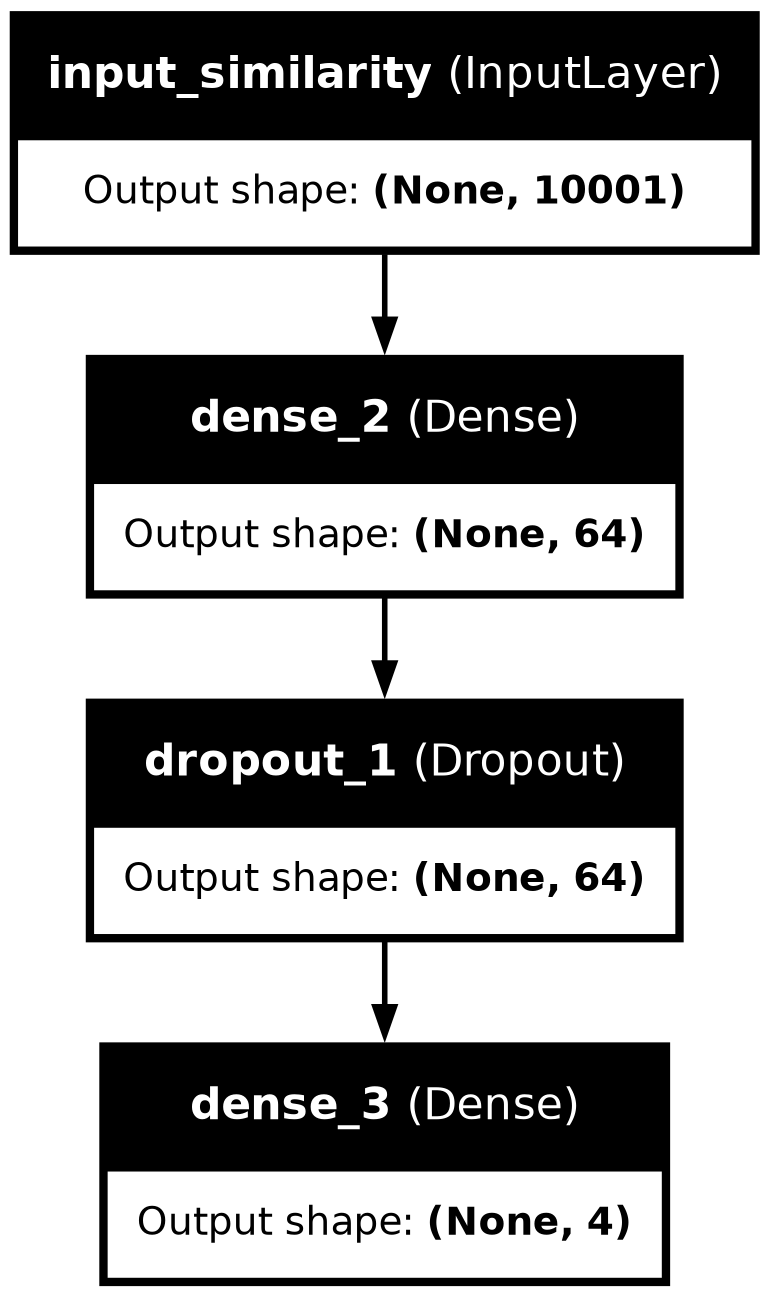

In [20]:
from tensorflow.keras.utils import to_categorical,plot_model

plot_model(model, to_file="model_tf-idf_mlp.png" , show_shapes=True, show_layer_names=True)

In [21]:
model_history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size_train)


Epoch 1/90
18/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4613 - loss: 1.3195

I0000 00:00:1713149821.253370      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713149821.269252      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5205 - loss: 1.2401

W0000 00:00:1713149823.158392      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713149823.893150      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.5218 - loss: 1.2376 - val_accuracy: 0.6251 - val_loss: 0.9564
Epoch 2/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6404 - loss: 0.9191 - val_accuracy: 0.7092 - val_loss: 0.7911
Epoch 3/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7324 - loss: 0.7499 - val_accuracy: 0.7774 - val_loss: 0.6646
Epoch 4/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7964 - loss: 0.6211 - val_accuracy: 0.8220 - val_loss: 0.5534
Epoch 5/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8391 - loss: 0.5117 - val_accuracy: 0.8537 - val_loss: 0.4623
Epoch 6/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8793 - loss: 0.4126 - val_accuracy: 0.8812 - val_loss: 0.3892
Epoch 7/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9066 - loss: 0.3383 - val_accuracy: 0.8999 - val_loss: 0.3359
Epoch 8/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9213 - loss: 0.2923 - val_accuracy: 0.9121 - val_loss: 0.

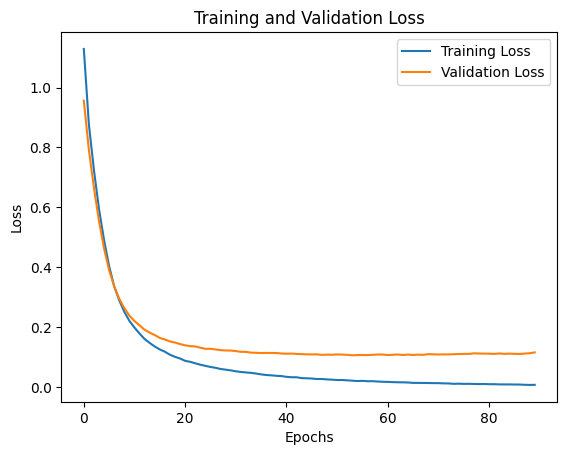

795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7743 - loss: 1.1364
Test Loss: 1.188632607460022
Test Accuracy: 0.770825982093811


W0000 00:00:1713149909.740262      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [22]:
# Save the training history
import matplotlib.pyplot as plt
training_loss_binorm = model_history.history['loss']
validation_loss_binorm = model_history.history['val_loss']

# Plot the loss
plt.plot(training_loss_binorm, label='Training Loss')
plt.plot(validation_loss_binorm, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss_binorm, accuracy_binorm = model.evaluate(np.stack(test_set), np.array(stan))
print('Test Loss:', loss_binorm)
print('Test Accuracy:', accuracy_binorm)

795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


W0000 00:00:1713149925.236448      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[3 3 3 ... 3 3 3]


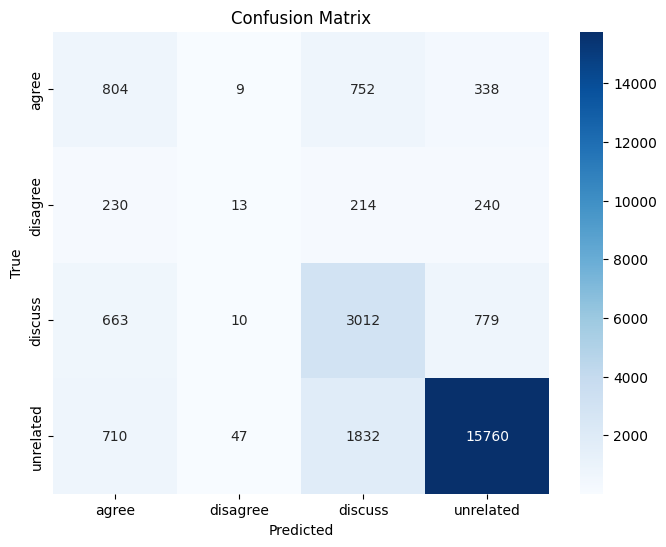

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'model_combined' is your trained model

# Get predictions on the test set
predictions = model.predict(np.stack(test_set))
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

# Compute the confusion matrix
conf_matrix = confusion_matrix(np.array(stan), predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['agree', 'disagree', 'discuss', 'unrelated'],
            yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate accuracy
RELATED = [0,1,2]
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
accuracy = accuracy_score(stan, predicted_labels)

# Calculate precision, recall, F1-score using scikit-learn
precision, recall, f1_score, _ = precision_recall_fscore_support(stan, predicted_labels, average='weighted')

# Define your custom score function
def score_submission(gold_labels, test_labels):
    score = 0.0

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25


    return score


def report_score(actual,predicted):
    score = score_submission(actual,predicted)
    best_score = score_submission(actual,actual)

    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score


# Calculate your custom score
custom_score = score_submission(stan, predicted_labels)
report_sc = report_score(stan, predicted_labels)

# Print all the metrics
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1_score)
print("Custom Score:", custom_score)


Score: 16118.5 out of 20825.75	(77.39697249798927%)
Custom Score: 16118.5


In [26]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, F1-score for each class using scikit-learn
precision, recall, f1_score, _ = precision_recall_fscore_support(stan, predicted_labels, average=None)

# Print class-wise F1 scores
for i in range(len(precision)):
    print(f"Class {i} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1_score[i]}")

# Print all the metrics
print("Accuracy:", accuracy)
print("Macro Precision:", precision.mean())
print("Macro Recall:", recall.mean())
print("Macro F1 Score:", f1_score.mean())
print("Custom Score:", custom_score)

Class 0 - Precision: 0.3340257582052347, Recall: 0.42249080399369415, F1-score: 0.37308584686774937
Class 1 - Precision: 0.16455696202531644, Recall: 0.018651362984218076, F1-score: 0.03350515463917526
Class 2 - Precision: 0.5184165232358003, Recall: 0.6747311827956989, F1-score: 0.5863344364415028
Class 3 - Precision: 0.9207220891511363, Recall: 0.8589023925009537, F1-score: 0.8887385101223708
Accuracy: 0.7708259552197694
Macro Precision: 0.48443033315437195
Macro Recall: 0.49369393556864116
Macro F1 Score: 0.4704159870176996
Custom Score: 16118.5


## LSTM 

In [19]:
X_train.shape[1]

10001

In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Concatenate, Bidirectional, LSTM, Dropout, Dense, BatchNormalization, LayerNormalization

# Assuming feature_size is defined
# feature_size = ? 

# Split data into train and validation sets
X_train, y_train = train_set, train_stances
X_val, y_val = valid_set, val_lab

# Convert validation data to numpy arrays
X_val = np.stack(X_val, axis=0)
y_val = np.array(y_val)

# Convert training data to numpy arrays
X_train = np.stack(X_train, axis=0)
y_train = np.array(y_train)

# Define input shape compatible with LSTM
input_similarity = Input(shape=(feature_size,), name='input_similarity')

reshaped_input = tf.keras.layers.Reshape((1, X_train.shape[1]))(input_similarity)

# LSTM layer
# LSTM layer
lstm_layer = LSTM(64)(reshaped_input)

# Output layer
output = Dense(4, activation='softmax')(lstm_layer)

# Create model
model_lstm = tf.keras.Model(inputs=input_similarity, outputs=output)

# Compile model
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
model_lstm.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_similarity (InputLayer)   │ (None, 10001)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 10001)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │     2,576,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,577,156 (9.83 MB)

 Trainable params: 2,577,156 (9.83 MB)

 Non-trainable params: 0 (0.00 B)

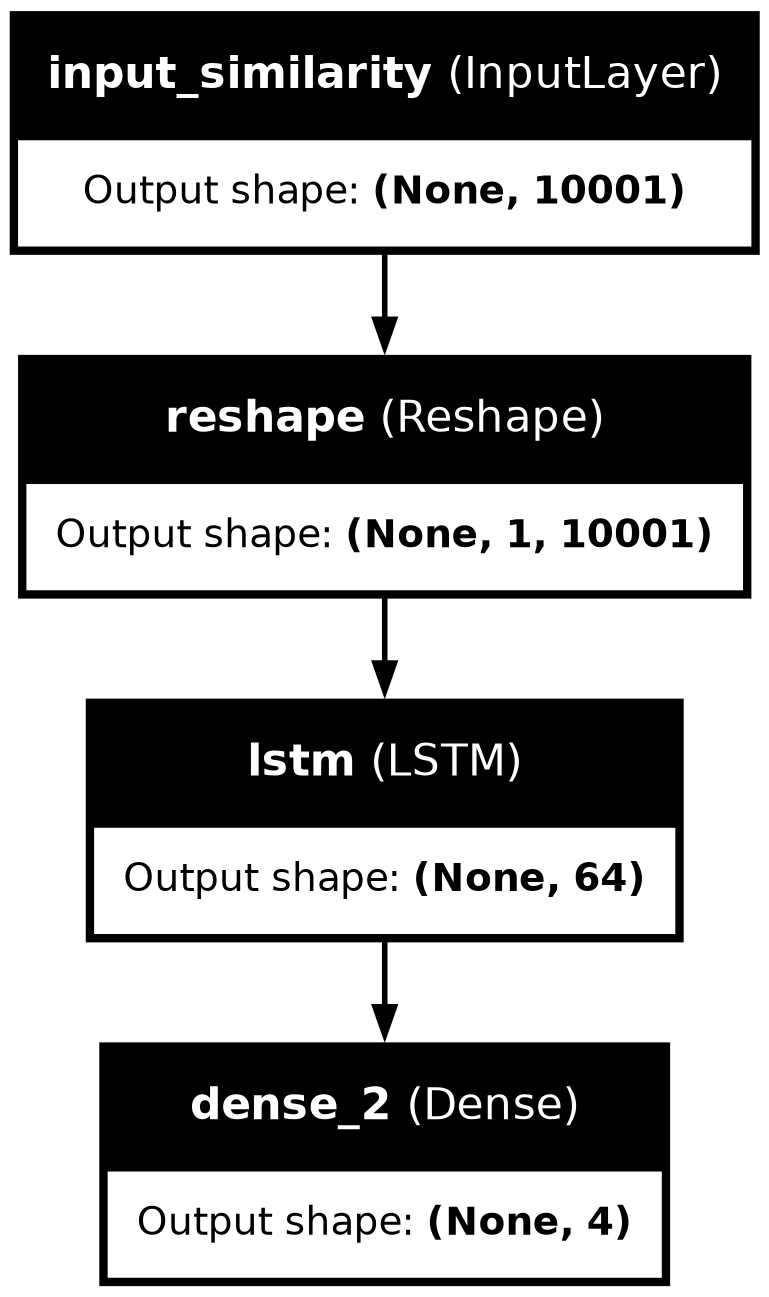

In [21]:
plot_model(model_lstm, to_file="model_tf-idf_lstm.png" , show_shapes=True, show_layer_names=True)

In [22]:
model_lstm_history=model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size_train)


Epoch 1/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4871 - loss: 1.2880 - val_accuracy: 0.5652 - val_loss: 1.0391
Epoch 2/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5942 - loss: 0.9893 - val_accuracy: 0.6277 - val_loss: 0.8866
Epoch 3/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6542 - loss: 0.8473 - val_accuracy: 0.7100 - val_loss: 0.7582
Epoch 4/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7404 - loss: 0.7071 - val_accuracy: 0.7725 - val_loss: 0.6418
Epoch 5/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8082 - loss: 0.5767 - val_accuracy: 0.8179 - val_loss: 0.5383
Epoch 6/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8507 - loss: 0.4716 - val_accuracy: 0.8470 - val_loss: 0.4507
Epoch 7/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8895 - loss: 0.3775 - val_accuracy: 0.8719 - val_loss: 0.3819
Epoch 8/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9133 - loss: 0.3072 - val_accuracy: 0.8917 - v

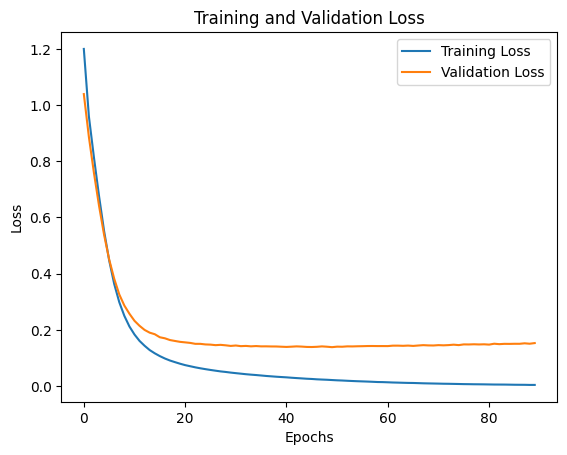

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9652 - loss: 0.1366
Test Loss: 0.15094229578971863
Test Accuracy: 0.9627560377120972


In [23]:
# Save the training history
import matplotlib.pyplot as plt
training_loss = model_lstm_history.history['loss']
validation_loss = model_lstm_history.history['val_loss']

# Plot the loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss_binorm, accuracy_binorm = model_lstm.evaluate(np.stack(test_set), np.array(stan))
print('Test Loss:', loss_binorm)
print('Test Accuracy:', accuracy_binorm)

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[1 3 3 ... 2 3 3]


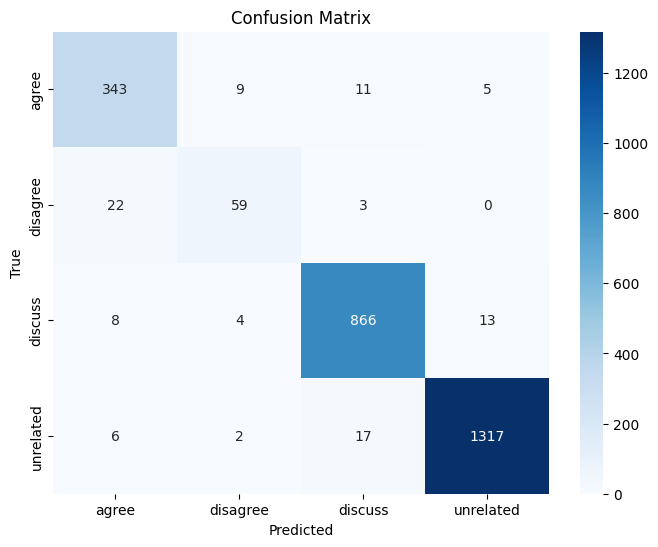

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'model_combined' is your trained model

# Get predictions on the test set
predictions = model_lstm.predict(np.stack(test_set))
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

# Compute the confusion matrix
conf_matrix = confusion_matrix(np.array(stan), predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['agree', 'disagree', 'discuss', 'unrelated'],
            yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate accuracy
RELATED = [0,1,2]
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
accuracy = accuracy_score(stan, predicted_labels)

# Calculate precision, recall, F1-score using scikit-learn
precision, recall, f1_score, _ = precision_recall_fscore_support(stan, predicted_labels, average='weighted')

# Define your custom score function
def score_submission(gold_labels, test_labels):
    score = 0.0

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25


    return score


def report_score(actual,predicted):
    score = score_submission(actual,predicted)
    best_score = score_submission(actual,actual)

    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score


# Calculate your custom score
custom_score = score_submission(stan, predicted_labels)
report_sc = report_score(stan, predicted_labels)

# Print all the metrics
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1_score)
print("Custom Score:", custom_score)


Score: 2270.0 out of 2349.5	(96.61630134071079%)
Custom Score: 2270.0


In [26]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, F1-score for each class using scikit-learn
precision, recall, f1_score, _ = precision_recall_fscore_support(stan, predicted_labels, average=None)

# Print class-wise F1 scores
for i in range(len(precision)):
    print(f"Class {i} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1_score[i]}")

# Print all the metrics
print("Accuracy:", accuracy)
print("Macro Precision:", precision.mean())
print("Macro Recall:", recall.mean())
print("Macro F1 Score:", f1_score.mean())
print("Custom Score:", custom_score)

Class 0 - Precision: 0.9050131926121372, Recall: 0.9320652173913043, F1-score: 0.9183400267737618
Class 1 - Precision: 0.7972972972972973, Recall: 0.7023809523809523, F1-score: 0.7468354430379748
Class 2 - Precision: 0.9654403567447045, Recall: 0.9719416386083053, F1-score: 0.9686800894854586
Class 3 - Precision: 0.9865168539325843, Recall: 0.981371087928465, F1-score: 0.9839372431826671
Accuracy: 0.962756052141527
Macro Precision: 0.9135669251466808
Macro Recall: 0.8969397240772568
Macro F1 Score: 0.9044482006199656
Custom Score: 2270.0


## BILSTM

In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Concatenate, Bidirectional, LSTM, Dropout, Dense, BatchNormalization, LayerNormalization

# Assuming feature_size is defined
# feature_size = ? 

# Split data into train and validation sets
X_train, y_train = train_set, train_stances
X_val, y_val = valid_set, val_lab

# Convert validation data to numpy arrays
X_val = np.stack(X_val, axis=0)
y_val = np.array(y_val)

# Convert training data to numpy arrays
X_train = np.stack(X_train, axis=0)
y_train = np.array(y_train)

# Define input shape compatible with LSTM
input_similarity = Input(shape=(feature_size,), name='input_similarity')

reshaped_input = tf.keras.layers.Reshape((1, X_train.shape[1]))(input_similarity)

# LSTM layer
# LSTM layer
lstm_layer = Bidirectional(LSTM(64))(reshaped_input)

# Output layer
output = Dense(4, activation='softmax')(lstm_layer)

# Create model
model_bilstm = tf.keras.Model(inputs=input_similarity, outputs=output)

# Compile model
model_bilstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
model_bilstm.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_similarity (InputLayer)   │ (None, 10001)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 10001)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │     5,153,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,154,308 (19.66 MB)

 Trainable params: 5,154,308 (19.66 MB)

 Non-trainable params: 0 (0.00 B)

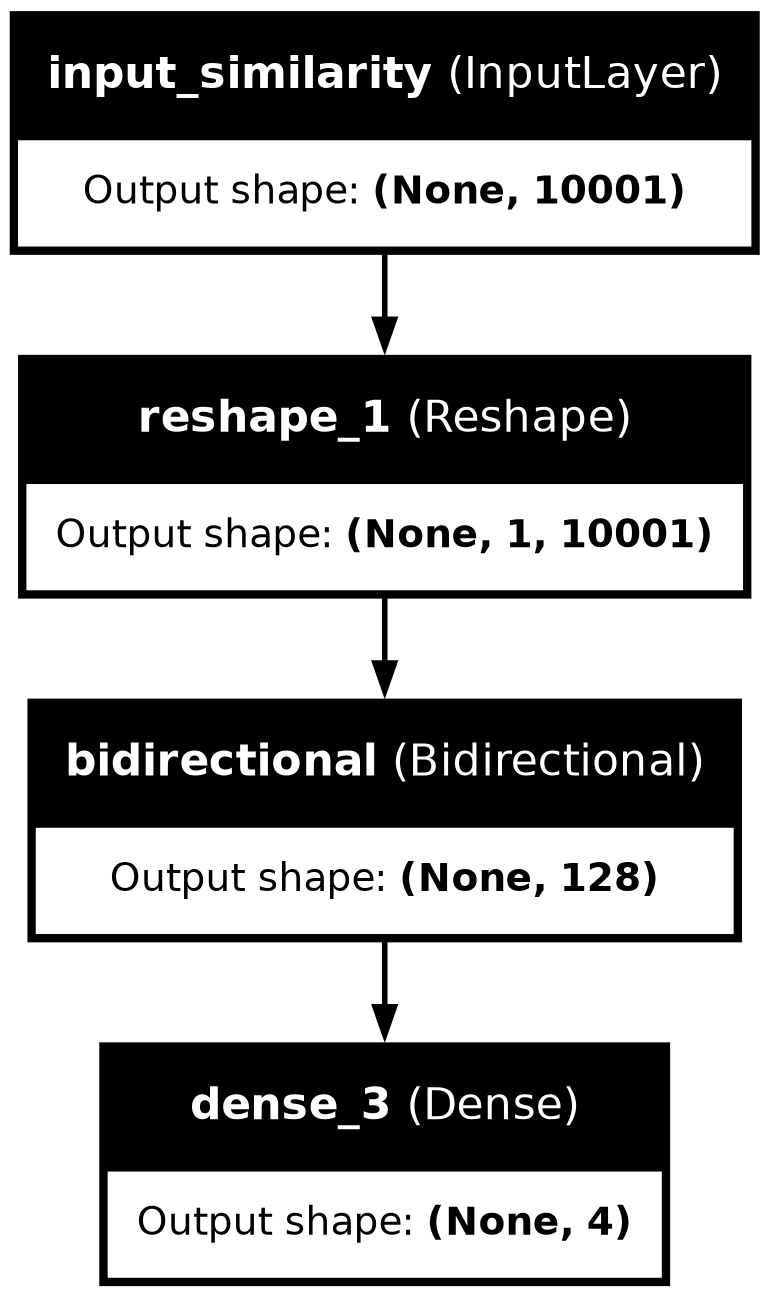

In [28]:
plot_model(model_bilstm, to_file="model_tf-idf_lstm.png" , show_shapes=True, show_layer_names=True)

In [29]:
model_bilstm_history=model_bilstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size_train)


Epoch 1/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5319 - loss: 1.2565 - val_accuracy: 0.6083 - val_loss: 0.9763
Epoch 2/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6262 - loss: 0.9341 - val_accuracy: 0.6765 - val_loss: 0.8032
Epoch 3/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7135 - loss: 0.7500 - val_accuracy: 0.7718 - val_loss: 0.6567
Epoch 4/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8065 - loss: 0.5780 - val_accuracy: 0.8235 - val_loss: 0.5219
Epoch 5/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8656 - loss: 0.4386 - val_accuracy: 0.8608 - val_loss: 0.4116
Epoch 6/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9029 - loss: 0.3394 - val_accuracy: 0.8917 - val_loss: 0.3340
Epoch 7/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9281 - loss: 0.2609 - val_accuracy: 0.9092 - val_loss: 0.2785
Epoch 8/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9445 - loss: 0.2112 - val_accuracy: 0.9218 - v

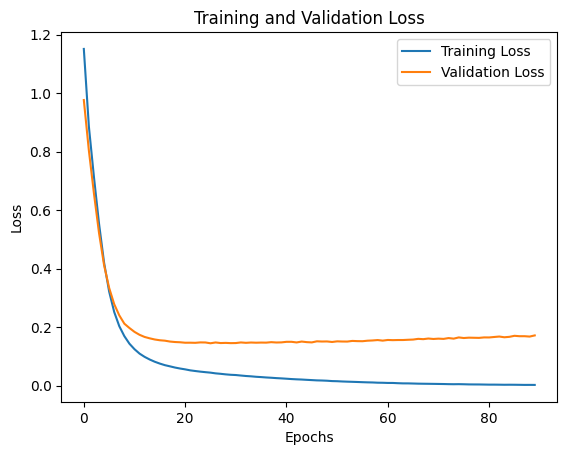

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9685 - loss: 0.1551
Test Loss: 0.15094229578971863
Test Accuracy: 0.9627560377120972


In [46]:
# Save the training history
import matplotlib.pyplot as plt
training_loss = model_bilstm_history.history['loss']
validation_loss = model_bilstm_history.history['val_loss']

# Plot the loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss_bi, accuracy_bi = model_bilstm.evaluate(np.stack(test_set), np.array(stan))
print('Test Loss:', loss_binorm)
print('Test Accuracy:', accuracy_binorm)

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


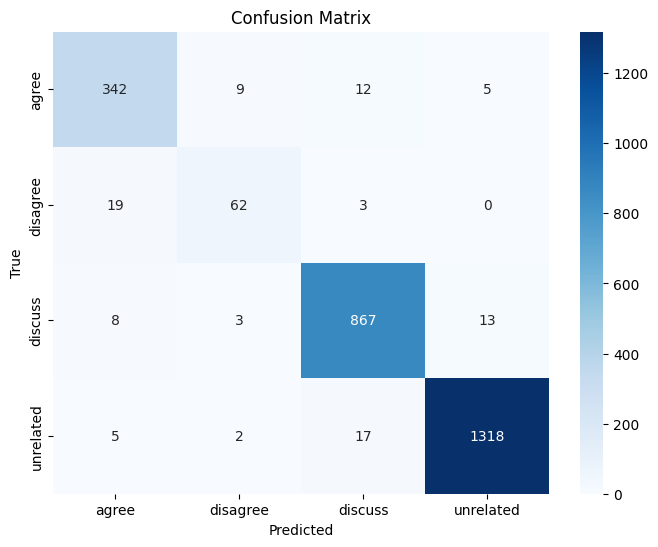

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Score: 2273.0 out of 2349.5	(96.74398808257077%)
Accuracy: 0.964245810055866
Precision: 0.9639640995513823
Recall: 0.964245810055866
F1 Score: 0.964027035744943
Custom Score: 2273.0
Class 0 - Precision: 0.9144385026737968, Recall: 0.9293478260869565, F1-score: 0.921832884097035
Class 1 - Precision: 0.8157894736842105, Recall: 0.7380952380952381, F1-score: 0.775
Class 2 - Precision: 0.96440489432703, Recall: 0.9730639730639731, F1-score: 0.9687150837988828
Class 3 - Precision: 0.9865269461077845, Recall: 0.9821162444113264, F1-score: 0.9843166542195668


(0.964245810055866,
 0.9639640995513823,
 0.964245810055866,
 0.964027035744943,
 2273.0)

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

class ModelEvaluator:
    def __init__(self, model, test_set, true_labels):
        self.model = model
        self.test_set = test_set
        self.true_labels = true_labels

    def plot_confusion_matrix(self):
        predictions = self.model.predict(np.stack(self.test_set))
        predicted_labels = np.argmax(predictions, axis=1)
        conf_matrix = confusion_matrix(self.true_labels, predicted_labels)

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['agree', 'disagree', 'discuss', 'unrelated'],
                    yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
        


    def calculate_metrics(self):
        predictions = self.model.predict(np.stack(self.test_set))
        predicted_labels = np.argmax(predictions, axis=1)

        acc = accuracy_score(self.true_labels, predicted_labels)
        precision, recall, f1, _ = precision_recall_fscore_support(self.true_labels, predicted_labels, average='weighted')

        def score_submission(gold_labels, test_labels):
            score = 0.0

            for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
                g_stance, t_stance = g, t
                if g_stance == t_stance:
                    score += 0.25
                    if g_stance != 'unrelated':
                        score += 0.50
                if g_stance in [0, 1, 2] and t_stance in [0, 1, 2]:
                    score += 0.25

            return score
        
        def report_score(actual,predicted):
            score = score_submission(actual,predicted)
            best_score = score_submission(actual,actual)

            print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
            return score*100/best_score

        custom_score = score_submission(self.true_labels, predicted_labels)
        report_sc = report_score(self.true_labels, predicted_labels)

        return acc, precision, recall, f1, custom_score, predicted_labels

    def evaluate(self):

        self.plot_confusion_matrix()
        acc, precision, recall, f1, custom_score, predicted_labels = self.calculate_metrics()

        print("Accuracy:", acc)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        print("Custom Score:", custom_score)

        class_precision, class_recall, class_f1, _ = precision_recall_fscore_support(self.true_labels, predicted_labels, average=None)
        for i in range(len(class_precision)):
            print(f"Class {i} - Precision: {class_precision[i]}, Recall: {class_recall[i]}, F1-score: {class_f1[i]}")

        return acc, precision, recall, f1, custom_score

# Assuming `model_lstm` is the trained model, `test_set` is the test set, and `stan` are the true labels



# Assuming 'model', 'test_data', and 'test_labels' are available
evaluator = ModelEvaluator(model_bilstm, test_set, stan)
evaluator.evaluate()

## Bilstm with Max Pooling

In [47]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, GlobalMaxPooling1D
import numpy as np

# Assuming feature_size is defined
# feature_size = ? 

# Split data into train and validation sets
X_train, y_train = train_set, train_stances
X_val, y_val = valid_set, val_lab

# Convert validation data to numpy arrays
X_val = np.stack(X_val, axis=0)
y_val = np.array(y_val)

# Convert training data to numpy arrays
X_train = np.stack(X_train, axis=0)
y_train = np.array(y_train)

# Define input shape compatible with LSTM
input_similarity = Input(shape=(feature_size,), name='input_similarity')

# Reshape input for LSTM layer
reshaped_input = tf.keras.layers.Reshape((1, X_train.shape[1]))(input_similarity)

# Bidirectional LSTM layer
lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(reshaped_input)

# Apply GlobalMaxPooling1D layer
max_pool = GlobalMaxPooling1D()(lstm_layer)

# Dropout layer
drop = Dropout(0.25)(max_pool)

# Output layer
output = Dense(4, activation='softmax')(drop)

# Create model
model_bilstm_maxpool = tf.keras.Model(inputs=input_similarity, outputs=output)

# Compile model
model_bilstm_maxpool.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
model_bilstm_maxpool.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_similarity (InputLayer)   │ (None, 10001)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1, 10001)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 1, 128)         │     5,153,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,154,308 (19.66 MB)

 Trainable params: 5,154,308 (19.66 MB)

 Non-trainable params: 0 (0.00 B)

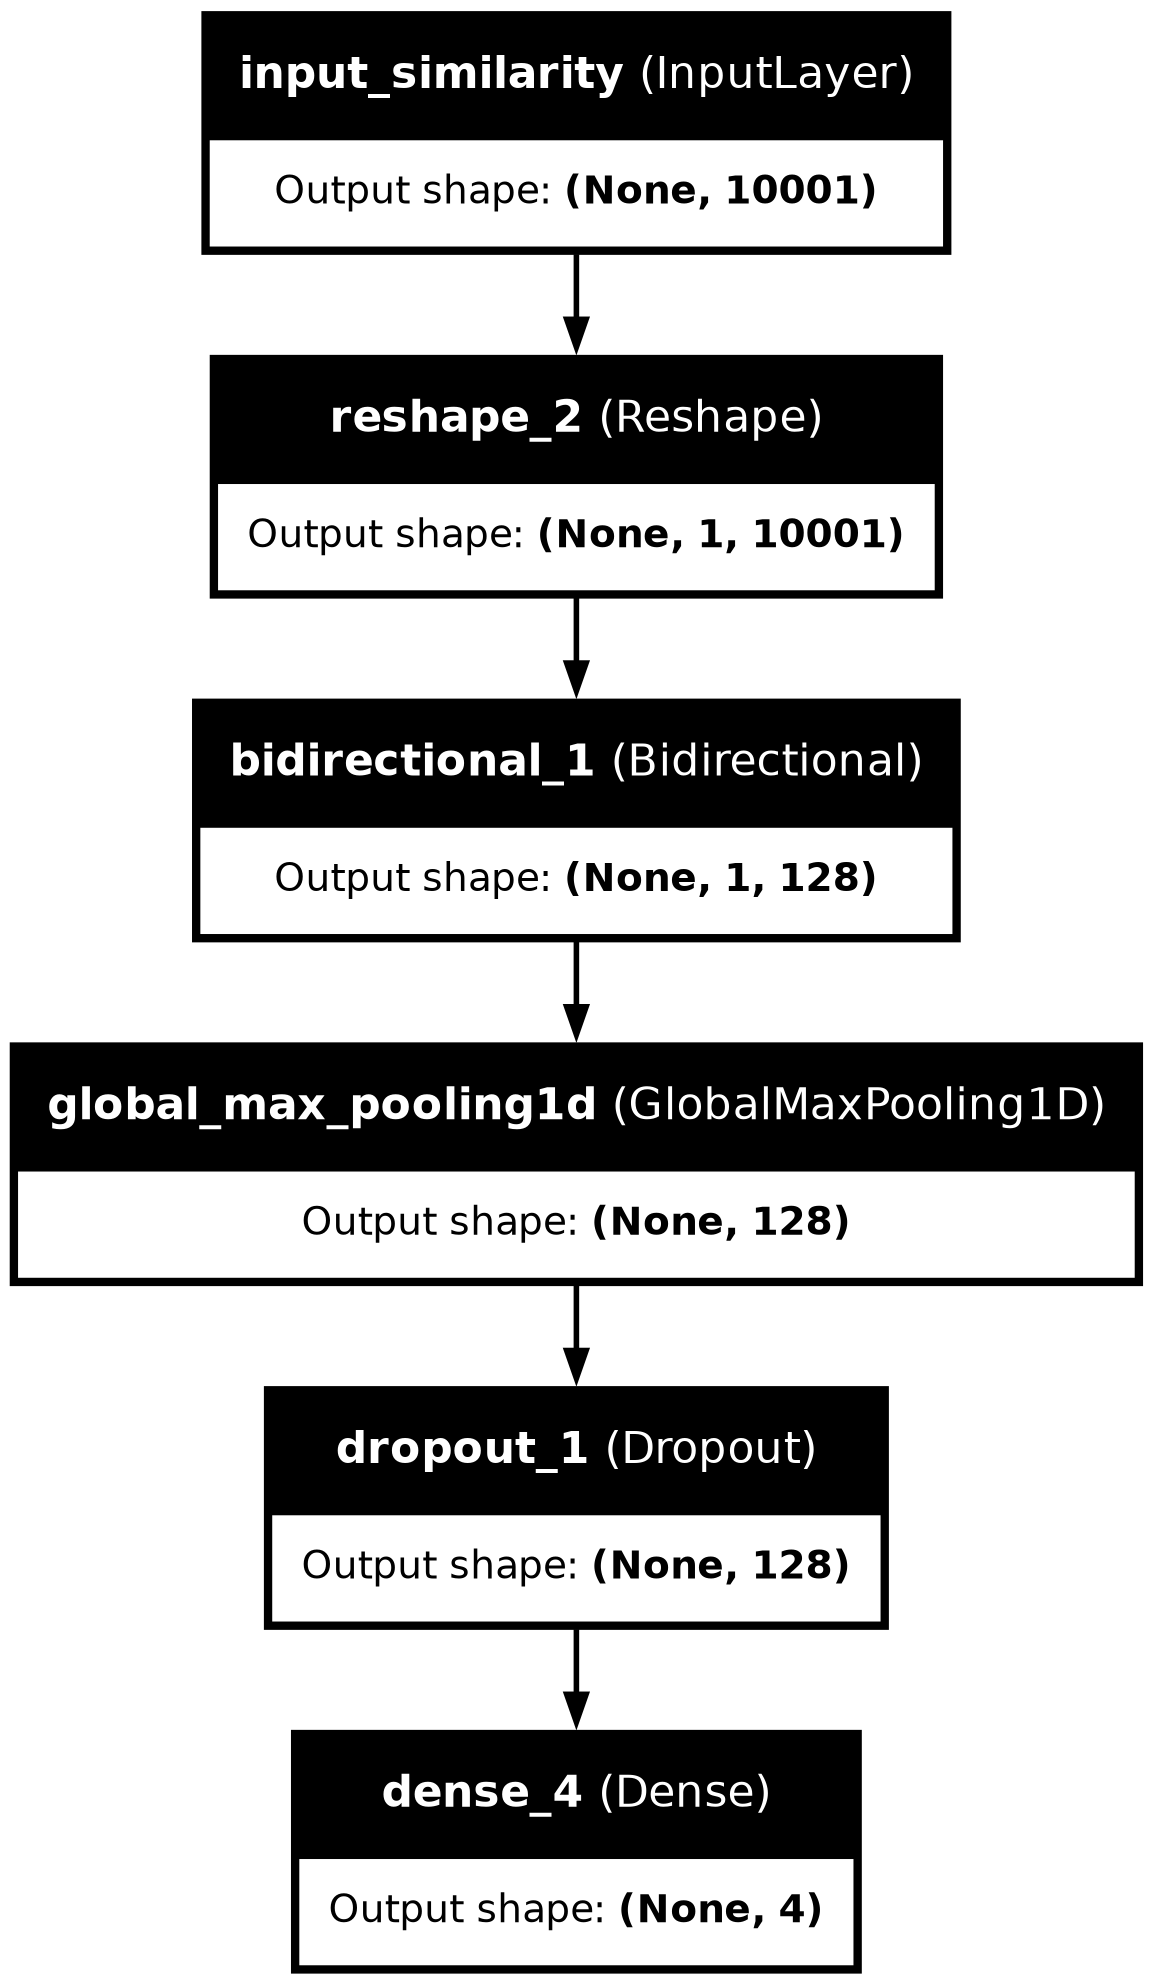

In [37]:
plot_model(model_bilstm_maxpool, to_file="model_tf-idf_bilstmpooling.png" , show_shapes=True, show_layer_names=True)

In [48]:
model_bilstm_maxpool_history=model_bilstm_maxpool.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size_train)


Epoch 1/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4883 - loss: 1.2573 - val_accuracy: 0.6091 - val_loss: 0.9891
Epoch 2/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6157 - loss: 0.9484 - val_accuracy: 0.6675 - val_loss: 0.8219
Epoch 3/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6995 - loss: 0.7679 - val_accuracy: 0.7647 - val_loss: 0.6735
Epoch 4/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7920 - loss: 0.6121 - val_accuracy: 0.8213 - val_loss: 0.5420
Epoch 5/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8515 - loss: 0.4656 - val_accuracy: 0.8555 - val_loss: 0.4322
Epoch 6/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8918 - loss: 0.3638 - val_accuracy: 0.8846 - val_loss: 0.3507
Epoch 7/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9146 - loss: 0.2883 - val_accuracy: 0.9013 - val_loss: 0.2935
Epoch 8/90
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9387 - loss: 0.2293 - val_accuracy: 0.9170 - v

In [ ]:
# Save the training history
import matplotlib.pyplot as plt
training_loss = model_bilstm_maxpool_history.history['loss']
validation_loss = model_bilstm_maxpool_history.history['val_loss']

# Plot the loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss_bi, accuracy_bi = model_bilstm_maxpool.evaluate(np.stack(test_set), np.array(stan))
print('Test Loss:', loss_binorm)
print('Test Accuracy:', accuracy_binorm)

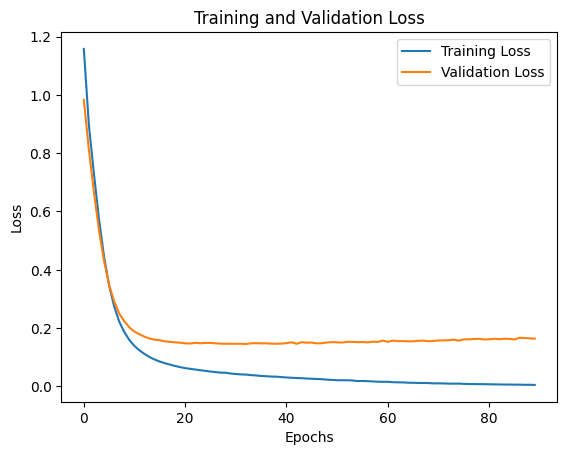

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


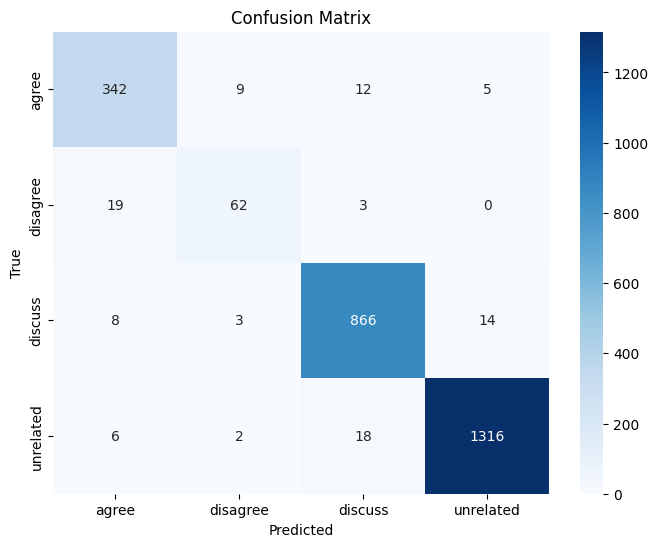

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Score: 2270.5 out of 2349.5	(96.63758246435411%)
Accuracy: 0.9631284916201117
Precision: 0.9628813221389612
Recall: 0.9631284916201117
F1 Score: 0.9629231663850901
Custom Score: 2270.5
Class 0 - Precision: 0.9074074074074074, Recall: 0.9320652173913043, F1-score: 0.9195710455764076
Class 1 - Precision: 0.8026315789473685, Recall: 0.7261904761904762, F1-score: 0.7625
Class 2 - Precision: 0.9665178571428571, Recall: 0.9719416386083053, F1-score: 0.9692221600447678
Class 3 - Precision: 0.9872659176029962, Recall: 0.9821162444113264, F1-score: 0.9846843481509151


(0.9631284916201117,
 0.9628813221389612,
 0.9631284916201117,
 0.9629231663850901,
 2270.5)

In [74]:
evaluator = ModelEvaluator(model_bilstm_maxpool, test_set, stan)
evaluator.evaluate()